# Tom and Jerry Image Classification
https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification

## Import libraries

In [3]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import squarify
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.feature import graycomatrix, graycoprops
from sklearn.cluster import KMeans
from itertools import combinations
from sklearn.metrics import silhouette_score

## Initialize

In [4]:
data_dir = './kaggle/input/tom_and_jerry/tom_and_jerry'
image_size = (224, 224)
subfolders = ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']
label_categories = ["Jerry","Tom","None","Both"]

### Tom & Jerry Label Balance

Jerry: 1240  Tom: 1930  None: 1528  Both: 780  

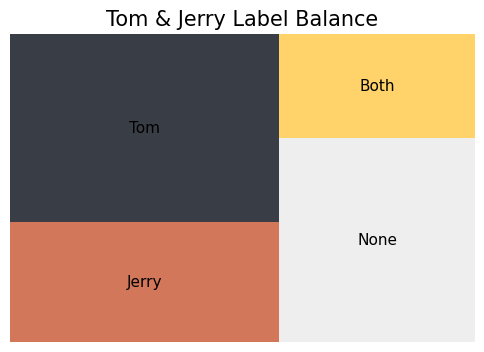

In [5]:
# Get the number of images for each class
image_counts = [len(os.listdir(os.path.join(data_dir, label))) for label in subfolders]

# Create a squarify plot of the class distribution
fig = plt.subplots(figsize = (6, 4))
# jerry, tom, none, both
colors = [ '#d27759','#393E46', '#EEEEEE',  '#FFD369']

squarify.plot(image_counts, label = label_categories, color = colors, text_kwargs = {"fontsize": 11})

plt.title("Tom & Jerry Label Balance", fontsize = 15)
plt.axis("off")

for i, count in enumerate(image_counts):
    print(f"{label_categories[i]}: {count}", end="  ")

## Functions to extract features of an image

In [6]:
# Function to preprocess the image
def preprocess_image(image):
    # Resize the image to a fixed size
    resized_image = cv2.resize(image, image_size)
    return resized_image

# Function to extract average RGB values
def extract_avg_rgb(image):
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
    # Calculate the average RGB values
    average_rgb = np.mean(image_rgb, axis=(0, 1))
    return average_rgb

# Function to extract color histogram features
def extract_color_histogram(image):
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Function to extract texture features using Gray-Level Co-occurrence Matrix (GLCM)
def extract_texture_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, [5], [0], 256, symmetric=True, normed=True)
    texture_features = np.hstack([graycoprops(glcm, prop).ravel() for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']])
    return texture_features

# Function to extract shape features
def extract_shape_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        contour_areas = [cv2.contourArea(contour) for contour in contours]
        return [len(contours), max(contour_areas), sum(contour_areas)]
    else:
        # If no contours are found, return null value
        return [0, 0, 0]  


# Function to extract colors of tom and jerry features
def extract_colors_features(image):
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Calculate the percentage of pixels in the image that match the color of Tom or Jerry
    tom_color_1 = np.array([95, 92, 87])  # Tom's characteristic color 1
    tom_color_2 = np.array([6, 69, 92])    # Tom's characteristic color 2
    tom_color_3 = np.array([195, 196, 191])    # Tom's characteristic color 3
    jerry_color_1 = np.array([140, 67, 41])  # Jerry's characteristic color 1
    jerry_color_2 = np.array([118, 64, 37])   # Jerry's characteristic color 2
    jerry_color_3 = np.array([225, 159, 115])   # Jerry's characteristic color 3


    
    # Calculate the mask for pixels matching the color of Tom or Jerry
    tom_mask = np.any(np.isclose(image_rgb, tom_color_1, atol=4), axis=-1) \
               | np.any(np.isclose(image_rgb, tom_color_2, atol=4), axis=-1) \
               | np.any(np.isclose(image_rgb, tom_color_3, atol=4), axis=-1) 
    jerry_mask = np.any(np.isclose(image_rgb, jerry_color_1, atol=1), axis=-1) \
                 | np.any(np.isclose(image_rgb, jerry_color_2, atol=1), axis=-1) \
                 | np.any(np.isclose(image_rgb, jerry_color_3, atol=1), axis=-1) 

    
    tom_pixel_percentage = np.mean(tom_mask)
    jerry_pixel_percentage = np.mean(jerry_mask) 
    return tom_pixel_percentage,  jerry_pixel_percentage

# Function to extract edge features using Canny edge detection
def extract_edge_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges) / (gray.shape[0] * gray.shape[1])  # Edge density
    return edge_density

# Function to extract Gabor features
def extract_gabor_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    frequencies = [0.1, 0.3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    features = []
    for frequency in frequencies:
        for angle in angles:
            g_kernel = cv2.getGaborKernel((21, 21), 4.0, angle, frequency, 0.5, 0, ktype=cv2.CV_32F)
            filtered = cv2.filter2D(gray, cv2.CV_32F, g_kernel)
            features.append(np.mean(filtered))
            features.append(np.std(filtered))
    return np.array(features)



# Function to extract features for each image
def extract_features(image_path):
    image = cv2.imread(image_path)
    image = preprocess_image(image)
    
    avg_rgb = extract_avg_rgb(image)
    avg_rgb_columns = {'Avg_RGB_R': avg_rgb[0],'Avg_RGB_g': avg_rgb[1], 'Avg_RGB_B': avg_rgb[2] }
    
    color_hist = extract_color_histogram(image)
    color_hist_columns = {'Color_Hist_'+str(i+1): hist_val for i, hist_val in enumerate(color_hist)}
    
    texture_features = extract_texture_features(image)
    texture_columns = {'Texture_'+prop: val for prop, val in zip(['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation'], texture_features)}

    shape_features = extract_shape_features(image)
    shape_columns = {'Shape_'+prop: val for prop, val in zip(['num_contours', 'max_contour_area', 'total_contour_area'], shape_features)}

    edge_density = extract_edge_features(image)
    edge_columns = {'Edge_Density': edge_density}

    tom_pixel_percentage, jerry_pixel_percentage = extract_colors_features(image)
    colors_columns = {'Tom_Pixel_Percentage': tom_pixel_percentage, 'Jerry_Pixel_Percentage': jerry_pixel_percentage}
    
    gabor_features = extract_gabor_features(image)
    gabor_columns = {'Gabor_'+str(i+1): g for i, g in enumerate(gabor_features)}
    
    all_columns = {**avg_rgb_columns, **color_hist_columns, **texture_columns, **shape_columns, **colors_columns, **edge_columns, **gabor_columns}

    return all_columns

## Create Dataframe with images data

In [7]:
data = []
image_files_list = []
labels = []

# Assuming subfolders is a list containing the subfolder names
for label, subfolder in enumerate(subfolders):
    folder_path = os.path.join(data_dir, subfolder)
    image_files = os.listdir(folder_path)
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        try:
            image_info = extract_features(image_path)
            # Add image info and label to lists
            image_files_list.append(os.path.join(subfolder, image_file))
            data.append(image_info)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# Create a DataFrame

df = pd.DataFrame(data)
df.insert(0, 'image_file', image_files_list)
df['Label'] = labels

In [8]:
df

,image_file,Avg_RGB_R,Avg_RGB_g,Avg_RGB_B,Color_Hist_1,Color_Hist_2,Color_Hist_3,Color_Hist_4,Color_Hist_5,Color_Hist_6,...,Gabor_8,Gabor_9,Gabor_10,Gabor_11,Gabor_12,Gabor_13,Gabor_14,Gabor_15,Gabor_16,Label
0,jerry/frame4473.jpg,112.128966,107.991988,87.107043,0.738695,0.007636,0.006173,0.001464,0.001845,0.000000,...,990.069763,11.243255,215.093842,11.901139,25.546318,11.242497,36.563461,11.901108,22.493332,0
1,jerry/frame1993.jpg,57.381178,49.199617,47.366291,0.631921,0.019470,0.007706,0.000000,0.000000,0.000000,...,444.202972,5.413600,129.480072,5.730477,27.641449,5.427465,28.781691,5.730477,24.647722,0
2,jerry/frame3451.jpg,96.768694,93.071130,85.450175,0.647569,0.001296,0.002890,0.003489,0.000249,0.000000,...,686.010193,9.654404,36.972767,10.397233,15.547724,9.820609,170.957748,10.397232,23.802858,0
3,jerry/frame5203.jpg,41.836794,54.374522,41.357083,0.790529,0.102939,0.229653,0.006629,0.001260,0.000000,...,680.668335,5.174377,148.116776,5.480175,49.175797,5.209764,50.898315,5.480174,38.506248,0
4,jerry/frame3104.jpg,84.929309,81.601244,82.275092,0.682351,0.024456,0.009940,0.002419,0.001893,0.000473,...,732.463745,8.307537,218.928406,9.215004,46.053703,8.702504,155.955978,9.215003,40.235214,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5473,tom_jerry_1/frame2026.jpg,86.548131,73.331314,70.174845,0.738955,0.012140,0.002207,0.000123,0.000000,0.000000,...,760.405457,8.093649,191.474167,8.567028,36.348637,8.105532,48.182560,8.567026,28.276775,3
5474,tom_jerry_1/frame1566.jpg,101.828304,88.313257,85.636121,0.761413,0.016374,0.012870,0.002230,0.005415,0.000000,...,778.416321,9.686623,217.184601,10.253465,57.960831,9.691252,80.565857,10.253464,52.908016,3
5475,tom_jerry_1/frame3624.jpg,60.206593,61.571209,58.938915,0.911843,0.237741,0.148093,0.003386,0.000990,0.005522,...,802.651672,6.405029,214.850342,6.782672,42.497612,6.381378,68.716164,6.782672,35.823433,3
5476,tom_jerry_1/frame3919.jpg,89.874402,57.575474,58.514290,0.794688,0.079075,0.307674,0.099141,0.003751,0.000500,...,860.247620,7.087979,194.561981,7.504679,56.992088,7.066214,79.569244,7.504677,66.670219,3


Save original dataframe into csv

In [9]:
df.to_csv('./data/original_data.csv', index=False)

## Preproccesing

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5478 entries, 0 to 5477
Columns: 544 entries, image_file to Label
dtypes: float32(528), float64(13), int64(2), object(1)
memory usage: 11.7+ MB


In [11]:
df.columns[df.isnull().any()]

Index([], dtype='object')

Create pipeline to preprocess df

In [12]:
df_ = df.drop(columns=['image_file', 'Label']).copy()

In [13]:
scaler_steps = [
    ('scaler', StandardScaler())  # Standarize features
]

pipeline_1 = Pipeline(steps=scaler_steps)
pipeline_1.fit(df_)            

Pipeline(steps=[('scaler', StandardScaler())])

In [14]:
pca_steps = [
    ('pca', PCA())  # PCA
]

pipeline_2 = Pipeline(steps=pca_steps)
pipeline_2.fit(df_)

Pipeline(steps=[('pca', PCA())])

Transform df with both pipelines and check which one yields better classification accuracy with RandomForestClassifier

In [15]:
def check_accuracy_with_pipeline(df, pipeline): 
    transformed_array = pipeline.transform(df)
    transformed_df = pd.DataFrame(transformed_array, columns=df.columns)
    transformed_df['Label'] = labels
    
    X = transformed_df.drop(columns=['Label'])
    y = transformed_df['Label']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf_class = RandomForestClassifier(random_state=42)
    rf_class.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = rf_class.predict(X_test)
    # Calculate accuracy for each model
    acc = accuracy_score(y_test, y_pred)
    return acc

def check_accuracy(df): 
    X = df.drop(columns=['Label'])
    y = df['Label']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf_class = RandomForestClassifier(random_state=42)
    rf_class.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = rf_class.predict(X_test)
    # Calculate accuracy for each model
    acc = accuracy_score(y_test, y_pred)
    return acc

In [16]:
# Calculate accuracy for each dataset
accuracy_original = check_accuracy(df.drop(columns=['image_file']))
accuracy_with_scaler = check_accuracy_with_pipeline(df_, pipeline_1)
accuracy_with_pca = check_accuracy_with_pipeline(df_, pipeline_2)

print("Accuracy with Original Dataset:", accuracy_original)
print("Accuracy with Standard Scaler:", accuracy_with_scaler)
print("Accuracy with PCA:", accuracy_with_pca)

Accuracy with Original Dataset: 0.9023722627737226
Accuracy with Standard Scaler: 0.9023722627737226
Accuracy with PCA: 0.8202554744525548


- Applying a Standard Scaler to the original dataset did not significantly affect the classification accuracy. The accuracy remained the same as the accuracy of the original dataset without any preprocessing.

- However, applying PCA to the dataset led to a decrease in classification accuracy. The accuracy dropped by approximately 8% compared to the accuracy of the original dataset.


Transform df with pipeline with just StandardScaler

In [17]:
transformed_array = pipeline_1.transform(df_)
transformed_df = pd.DataFrame(transformed_array, columns=df_.columns)
transformed_df['Label'] = labels

### Split dataframe into training, validation and testing

In [18]:
train_data, test_data = train_test_split(transformed_df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

Save preprocessed train, val and test dataframes into csv

In [19]:
train_data.to_csv('./data/train_data.csv', index=False)
val_data.to_csv('./data/val_data.csv', index=False)
test_data.to_csv('./data/test_data.csv', index=False)

In [20]:
X_train = train_data.drop(columns='Label')  
y_train = train_data['Label'] 

X_val = val_data.drop(columns='Label')  
y_val = val_data['Label'] 

X_test = test_data.drop(columns='Label')  
y_test= test_data['Label'] 

## Random Forest Classifier

In [21]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'max_features': ['sqrt', 'log2'],  # The number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 6],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

Search for the best model and hyperparameters

In [22]:
best_accuracy = 0
best_train_acc = 0
best_val_acc = 0
best_params = None
best_rf_class = None


for n_estimators in param_grid['n_estimators']:
    for criterion in param_grid['criterion']:
        for max_features in param_grid['max_features']:
            for min_samples_split in param_grid['min_samples_split']:
                for min_samples_leaf in param_grid['min_samples_leaf']:
                    # Create and train the model with current parameters
                    rf_model = RandomForestClassifier(
                        n_estimators=n_estimators,
                        criterion=criterion,
                        max_features=max_features,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        random_state=42
                    )
                    rf_model.fit(X_train, y_train)
                    
                    # Predict on training set
                    y_train_pred = rf_model.predict(X_train)
                    # Predict on validation set
                    y_val_pred = rf_model.predict(X_val)
                    
                    # Calculate accuracies
                    train_accuracy = accuracy_score(y_train, y_train_pred)
                    val_accuracy = accuracy_score(y_val, y_val_pred)
                    
                    # Calculate avg accuracy
                    accuracy = (train_accuracy + val_accuracy) / 2
                    
                    # Check if current parameters yield the best accuracy
                    if accuracy > best_accuracy:
                        best_rf_class = rf_model
                        best_accuracy = accuracy
                        best_train_acc = train_accuracy
                        best_val_acc = val_accuracy
                        
                        best_params = {
                            'n_estimators': n_estimators,
                            'criterion': criterion,
                            'max_features': max_features,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf
                        }

print("Best Train Accuracy:", best_train_acc)
print("Best Val Accuracy:", best_val_acc)
print("Best Avg Accuracy:", best_accuracy)
print("Best Hyperparameters:", best_params)

Best Train Accuracy: 1.0
Best Val Accuracy: 0.9030786773090079
Best Avg Accuracy: 0.9515393386545039
Best Hyperparameters: {'n_estimators': 200, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1}


In [23]:
def evaluate_performance(model, X, y):
    # Predict the labels
    y_pred = model.predict(X)

    # Calculate accuracy
    accuracy = accuracy_score(y, y_pred)
    print("Accuracy:", accuracy)

    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

#### Results for test data

Accuracy: 0.8941605839416058

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       269
           1       0.89      0.96      0.92       372
           2       0.86      0.88      0.87       295
           3       0.98      0.81      0.88       160

    accuracy                           0.89      1096
   macro avg       0.91      0.88      0.89      1096
weighted avg       0.90      0.89      0.89      1096



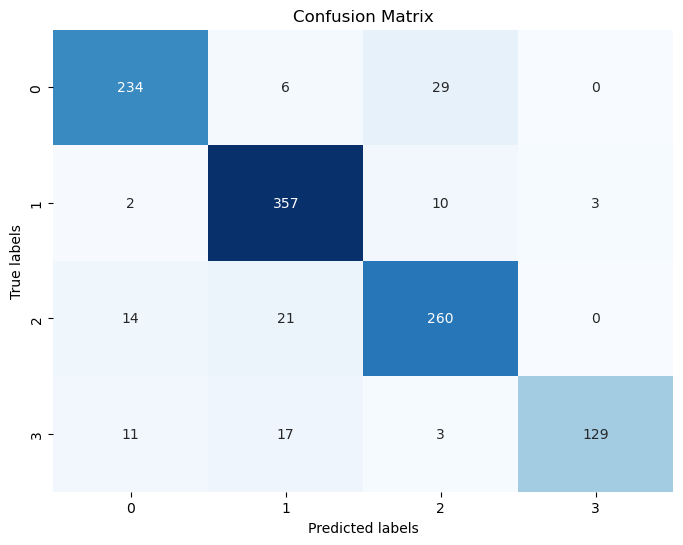

In [24]:
evaluate_performance(best_rf_class, X_test, y_test)

### Evaluate model with images of different dataset 
Images extracted from https://youtu.be/n2VPjut4rek?si=sIDvTKdj_kZl-rQv

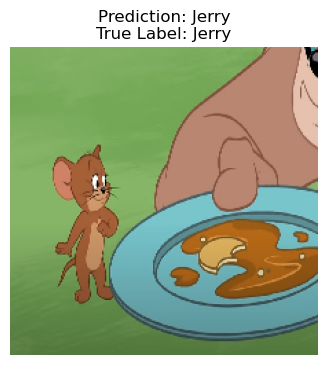

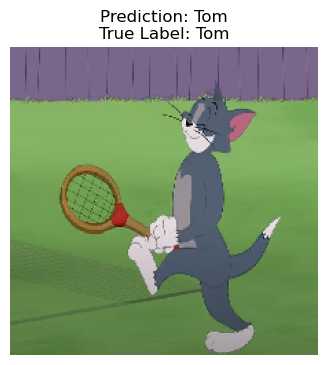

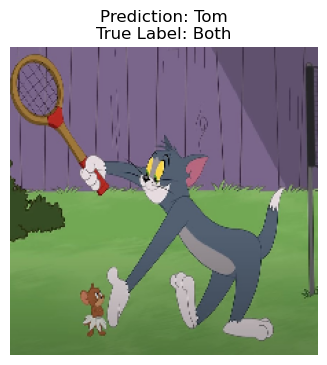

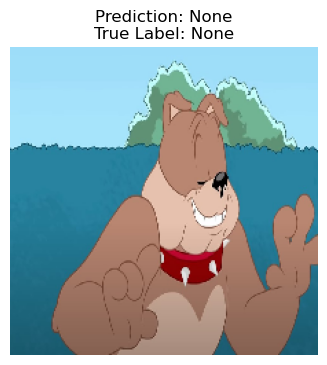

In [47]:
import tensorflow as tf

test_imgs_path = {'./test_data/jerry_frame.jpg': 0,  
                  './test_data/tom_frame.jpg': 1, 
                  './test_data/both_frame.jpg': 3, 
                  './test_data/none_frame.jpg': 2}

for image_path, true_label in test_imgs_path.items():
    img_info = extract_features(image_path)
    img_df = pd.DataFrame([img_info])
    transformed_array = pipeline_1.transform(img_df)
    transformed_df = pd.DataFrame(transformed_array, columns=img_df.columns)
    prediction = best_rf_class.predict(transformed_df)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    plt.figure(figsize=(8, 4))
    plt.imshow(img)
    title = f"Prediction: {label_categories[prediction[0]]}"
    title += f"\nTrue Label: {label_categories[true_label]}"
    plt.title(title)
    plt.axis('off')
    plt.show()

## K-means

In [ ]:
correlation_matrix = df.drop(columns=['image_file', 'Label']).corr()
correlation_matrix

,Avg_RGB_R,Avg_RGB_g,Avg_RGB_B,Color_Hist_1,Color_Hist_2,Color_Hist_3,Color_Hist_4,Color_Hist_5,Color_Hist_6,Color_Hist_7,...,Gabor_7,Gabor_8,Gabor_9,Gabor_10,Gabor_11,Gabor_12,Gabor_13,Gabor_14,Gabor_15,Gabor_16
Avg_RGB_R,1.000000,0.576804,0.407522,-0.214302,-0.206022,-0.128037,0.040989,0.073115,0.062091,0.183449,...,0.788869,0.518094,0.697275,0.376640,0.789123,0.237225,0.793611,0.243017,0.789017,0.251075
Avg_RGB_g,0.576804,1.000000,0.754252,-0.420450,-0.351372,-0.285808,-0.210075,-0.162663,-0.166963,0.092419,...,0.951795,0.491570,0.895714,0.436249,0.951682,0.134939,0.947599,-0.038942,0.951725,0.110040
Avg_RGB_B,0.407522,0.754252,1.000000,-0.383653,-0.348580,-0.235058,-0.151235,-0.125474,-0.154455,0.092465,...,0.766112,0.463130,0.726041,0.439502,0.765858,0.143029,0.764484,-0.094003,0.765942,0.121939
Color_Hist_1,-0.214302,-0.420450,-0.383653,1.000000,0.242396,0.136156,0.090354,0.012028,0.021240,-0.274359,...,-0.398893,0.303592,-0.346572,0.065501,-0.399281,0.115788,-0.398147,0.185789,-0.399032,0.125831
Color_Hist_2,-0.206022,-0.351372,-0.348580,0.242396,1.000000,0.239574,0.104603,-0.015322,0.016275,-0.026926,...,-0.346892,-0.049356,-0.333141,-0.101009,-0.346851,0.019289,-0.344215,-0.039076,-0.346865,0.029134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gabor_12,0.237225,0.134939,0.143029,0.115788,0.019289,0.105135,0.079857,0.004986,0.041927,0.091494,...,0.192668,0.406358,0.111381,0.326512,0.193243,1.000000,0.193211,0.326223,0.193226,0.842788
Gabor_13,0.793611,0.947599,0.764484,-0.398147,-0.344215,-0.259397,-0.138380,-0.093994,-0.104244,0.139345,...,0.998813,0.566500,0.923089,0.476469,0.998792,0.193211,1.000000,0.051933,0.998791,0.180052
Gabor_14,0.243017,-0.038942,-0.094003,0.185789,-0.039076,-0.028092,0.044520,-0.003656,0.148371,-0.009500,...,0.051670,0.166444,-0.047453,-0.130813,0.052305,0.326223,0.051933,1.000000,0.052349,0.375216
Gabor_15,0.789017,0.951725,0.765942,-0.399032,-0.346865,-0.260723,-0.140019,-0.094420,-0.104677,0.138336,...,0.999994,0.565894,0.923218,0.476668,0.999998,0.193226,0.998791,0.052349,1.000000,0.179465


Function to check if a combination contains duplicate prefixes to avoid meaningless correlations

In [ ]:
def has_duplicate_prefix(combination):
    prefixes = set()
    for column in combination:
        prefix = column.split('_')[0] 
        if prefix in prefixes:
            return True
        prefixes.add(prefix)
    return False

Iterate over all combinations of variables and check if their correlation exceeds the threshold

In [ ]:
combinations_variables = []
threshold = 0.8  # Correlation threshold

for combination in combinations(correlation_matrix.columns, 3):
    if has_duplicate_prefix(combination):
        continue
    correlation_sum = 0
    count = 0
    for i in range(len(combination)):
        for j in range(i + 1, len(combination)):
            correlation_sum += abs(correlation_matrix.loc[combination[i], combination[j]])
            count += 1
    average_correlation = correlation_sum / count
    if average_correlation > threshold:
        combinations_variables.append(list(combination))

Perform clustering with different variable combinations and numbers of clusters

In [ ]:
best_combination = None
best_silhouette_score = -1
best_labels = None

for idx, variables in enumerate(combinations_variables):
    for n_clusters in range(3, 6):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
        kmeans.fit(df[variables])
        silhouette_avg = silhouette_score(df[variables], kmeans.labels_)

        if silhouette_avg > best_silhouette_score:
            best_combination = (variables, n_clusters)
            best_silhouette_score = silhouette_avg
            best_labels = kmeans.labels_
            
print(f'Best combination: {best_combination}, Silhouette Score: {best_silhouette_score}')

Best combination: (['Avg_RGB_g', 'Shape_max_contour_area', 'Gabor_13'], 3), Silhouette Score: 0.6116834156756844


Create a DataFrame for the selected variables and their assigned clusters

In [ ]:
df_cluster = df[['image_file']+ best_combination[0]].copy()
df_cluster['Cluster'] = best_labels
df_cluster

,image_file,Avg_RGB_g,Shape_max_contour_area,Gabor_13,Cluster
0,jerry/frame4473.jpg,107.991988,17356.5,11.242497,0
1,jerry/frame1993.jpg,49.199617,788.0,5.427465,1
2,jerry/frame3451.jpg,93.071130,21198.5,9.820609,0
3,jerry/frame5203.jpg,54.374522,1191.5,5.209764,1
4,jerry/frame3104.jpg,81.601244,5977.0,8.702504,1
...,...,...,...,...,...
5473,tom_jerry_1/frame2026.jpg,73.331314,9152.0,8.105532,1
5474,tom_jerry_1/frame1566.jpg,88.313257,7460.5,9.691252,1
5475,tom_jerry_1/frame3624.jpg,61.571209,7572.5,6.381378,1
5476,tom_jerry_1/frame3919.jpg,57.575474,10304.0,7.066214,1


### Analysis across clusters

Do .describe() for each cluster

In [ ]:
for cluster_label in df_cluster['Cluster'].unique():
    print(f"\nCluster {cluster_label}:")
    print(df_cluster[df_cluster['Cluster'] == cluster_label].drop(columns=['image_file', 'Cluster']).describe())


Cluster 0:
         Avg_RGB_g  Shape_max_contour_area     Gabor_13
count  1677.000000             1677.000000  1677.000000
mean     96.992983            16449.006261    10.133418
std      13.664645             3606.727012     1.124896
min      46.845902            10427.000000     6.481795
25%      89.159459            13397.500000     9.516487
50%      98.122110            16283.500000    10.217087
75%     105.682797            19203.000000    10.790801
max     166.568499            23814.500000    17.056652

Cluster 1:
         Avg_RGB_g  Shape_max_contour_area     Gabor_13
count  2641.000000             2641.000000  2641.000000
mean     73.247493             4355.779061     7.534076
std      17.818878             3052.983015     1.642640
min       0.000000                0.000000     0.000000
25%      62.880959             1560.000000     6.530787
50%      73.668945             4088.500000     7.637490
75%      85.415517             6800.000000     8.706079
max     135.523736      


**1. Cluster 0 contains 1677 data points (30.61% of the total)**

- Avg_RGB_g: The mean average green value for this cluster is approximately 96.99, with a standard deviation of 13.66. The minimum value is 46.846, and the maximum value is 166.57.
- Shape_max_contour_area: The mean maximum contour area for this cluster is approximately 16449, with a standard deviation of 3606.72. The minimum value is 10427.00, and the maximum value is 23814.5.
- Gabor_13: The mean value for the Gabor feature 13 in this cluster is approximately 10.13, with a standard deviation of 1.12. The minimum value is 0.00, and the maximum value is 17.05.

**2. Cluster 1 contains 2641 data points (48.21 of the total)**

- Avg_RGB_g: The mean average green value for this cluster is approximately 73.25, with a standard deviation of 17.82. The minimum value is 0, and the maximum value is 135.52.
- Shape_max_contour_area: The mean maximum contour area for this cluster is approximately 4355.78, with a standard deviation of 3052.98. The minimum value is 0.00, and the maximum value is 10409.00.
- Gabor_13: The mean value for the Gabor feature 13 in this cluster is approximately 7.53, with a standard deviation of 1.64. The minimum value is 6.53, and the maximum value is 12.60.

**3. Cluster 2 contains 1160 data points (21.17% of the total)**

- Avg_RGB_g: The mean average green value for this cluster is approximately 123.30, with a standard deviation of 17.64. The minimum value is 76.93, and the maximum value is 193.23.
- Shape_max_contour_area: The mean maximum contour area for this cluster is approximately 31164.37, with a standard deviation of 5722.84. The minimum value is 23844.00, and the maximum value is 49694.50.
- Gabor_13: The mean value for the Gabor feature 13 in this cluster is approximately 12.49, with a standard deviation of 1.65. The minimum value is 8.51, and the maximum value is 19.32. 

Cluster 2 stands out for having significantly higher values in the features compared to the other clusters. It exhibits higher average green values and larger contour areas, suggesting potentially richer and more detailed images. Additionally, Cluster 2 also demonstrates higher mean values for the Gabor feature 13, indicating distinctive textural characteristics.

In contrast, Cluster 1 displays lower values across the features when compared to the other clusters. It is characterized by lower average green values and smaller contour areas, suggesting simpler and less detailed images. The mean value of Gabor feature 13 in Cluster 1 is also comparatively lower.

Cluster 0 falls between Clusters 1 and 2, exhibiting moderate values in the features. While it does not reach the extremes observed in Clusters 1 and 2, it still demonstrates notable characteristics, placing it in the middle ground in terms of feature values.


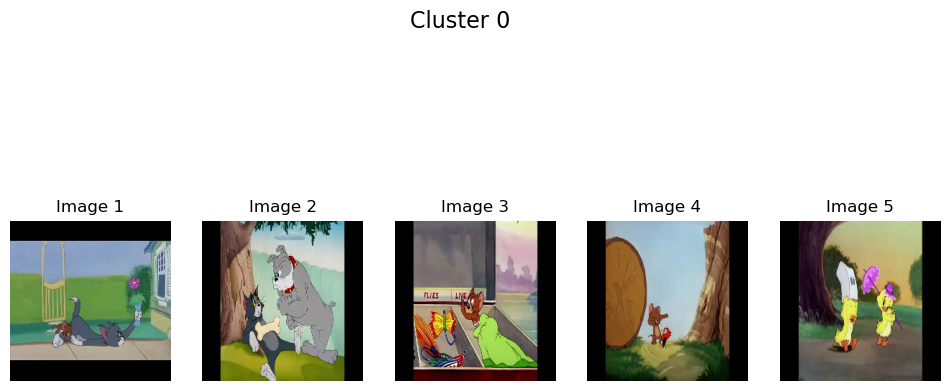

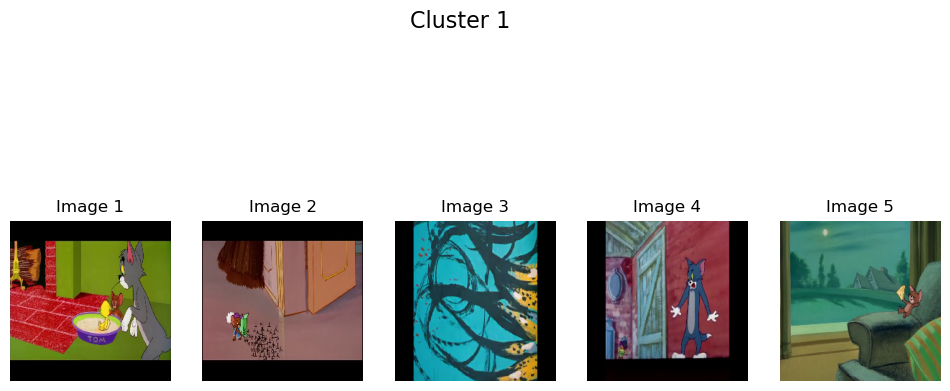

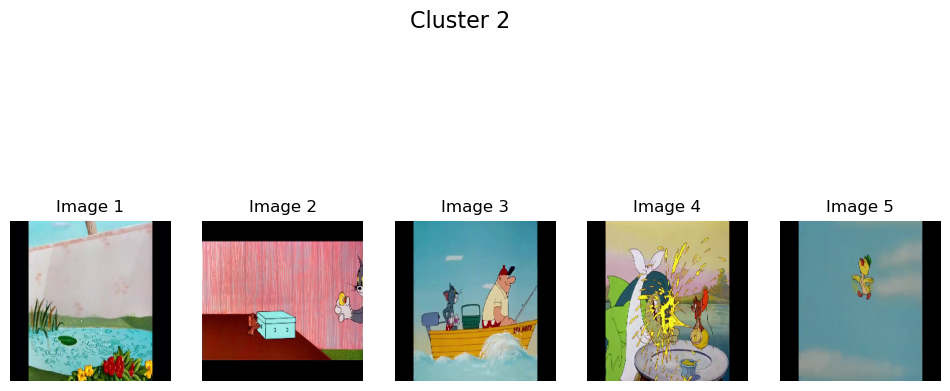

In [ ]:

def display_image_clusters(df, data_dir):
    clusters = df['Cluster'].unique()
    
    for cluster_label in clusters:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f"Cluster {cluster_label}", fontsize=16)
        
        subset = df[df['Cluster'] == cluster_label].sample(5, random_state=42)
        image_paths = subset['image_file'].apply(lambda x: os.path.join(data_dir, str(x))).tolist()
        
        for i, image_path in enumerate(image_paths):
            plt.subplot(1, 5, i + 1)
            img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Image {i+1}")

        plt.show()
display_image_clusters(df_cluster, data_dir)